In [ ]:
# here I am attempting to solve the first scenario of the requirements
# most of the stuff to solve this is done in the labs
# Scenario 1 (real world) - you receive a test set containing 55 scanned images annotated with the option (F or I) and with the digit (1, 2, 3 or 4). For each image you have
# to output the corresponding grade. Each correctly labeled scanned image will worth
# 0.03 points for a total of 1.65 points;

In [ ]:
# Basically, I will do the following steps:
# 1. Apply filters on images and detect the edges (canny edge?)
#    1.a grayscale the image
#    1.b apply filter (gaussian, sobel?)
#    1.c canny edge detection?
# 2. Detect lines
#    2.a Detect horizontal lines
#    2.b Detect vertical lines
#    2.c Merge image
#3. Detect boxes and create an inside, smaller box, as to not count the edges
#    3.a Detect boxes (lab 3.1)
#    3.b Verify mean color inside the boxes and mark as green with X and red without X
#    3.c Store the data and compare it to the answers in the files
#    3.d Do this on all files and see accuracy

In [1]:
# imports
# Required libraries to be installed: Pillow, OpenCV
import cv2 as cv
import numpy as np
import glob
import os
import pickle
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, display
import PIL.Image
import io

In [33]:
base_folder = './Files/images/' # change this on your machine
images = glob.glob(os.path.join(base_folder, "image_*.jpg")) 
char_to_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
image_index = 1

In [34]:
# global variables

# kernel size. h and v stand for orientation
# hk_size = 3
# vk_size = 3

In [281]:
# show image function is taken from Andrei Manolache outside of the project scope, I trust it does not count as plagiarism 
def show_image(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def read_image(index):
    image = cv.imread(images[index])
    return cv.resize(image, (0, 0), fx=0.15, fy=0.15)

def split_first_table(image):
    image_h, image_w, channels = image.shape
    return image[int(0.45 * image_h):int(image_h * 0.88), int(image_w * 0.1): int(image_w * 0.4)]

def split_second_table(image):
    image_h, image_w, channels = image.shape
    return image[int(0.45 * image_h):int(image_h * 0.88), int(image_w * 0.60): int(image_w * 0.90)]

def apply_filters(image):
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return image_gray

def get_binary_image(image_gray):
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(imgage_gray,meanValue, 255, cv.THRESH_BINARY_INV)

def horizontal_kernel(hk_size=11):
    kernel = np.array([hk_size * [0], hk_size * [1], hk_size * [0]])
    kernel = kernel / kernel.sum()
    return kernel

def vertical_kernel(vk_size=11):
#     kernel = np.array(vk_size * [int(vk_size / 2) * [0] + [1] + int(vk_size / 2) * [0]])
    kernel = np.array([[0,1,0],[0,1,0],[0,1,0]])                
    kernel = kernel / kernel.sum()
    return kernel

def filter_vertical(image_gray):    
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(image_gray, mean_value, 255, cv.THRESH_BINARY_INV)
    thresholded = image_th
    filtered = 255 - cv.filter2D(255 - thresholded, -1, vertical_kernel())
    filtered[filtered < 255] = 0
    filtered_vertical = filtered
    return filtered_vertical


def filter_horizontal(image_gray):    
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(image_gray, mean_value, 255, cv.THRESH_BINARY_INV)
    thresholded = image_th
    filtered = 255 - cv.filter2D(255 - thresholded, -1, horizontal_kernel())
    filtered[filtered < 255] = 0
    filtered_horizontal = filtered
    return filtered_horizontal

def get_horizontal_lines(image_gray, filtered_horizontal, num_lines):
    mask = filtered_horizontal // 255
    res = np.sum(mask, axis=1) 
    res = res.argsort() 
    h_img = np.dstack((filtered_horizontal, filtered_horizontal, filtered_horizontal))
    lines = [] #  _ x 
    for i in range(num_lines+1):
        cv.line(h_img, (0, res[-i]), (h_img.shape[1], res[-i]), (0, 0, 255), 2) 
        lines.append([(0, res[-i]), (h_img.shape[1], res[-i])])
    
    lines.sort(key=lambda coords: coords[0][1])

    return lines

def get_vertical_lines(image_gray, filtered_vertical, num_lines):
    mask = filtered_vertical // 255
    res = np.sum(mask, axis=0) 
    res = res.argsort() 
    v_img = np.dstack((filtered_vertical, filtered_vertical, filtered_vertical))
    lines = [] #  _ x 
    for i in range(num_lines+1):
        cv.line(v_img, (res[-i], 0), (res[-i], v_img.shape[0]), (0, 0, 255), 1) 
        lines.append([(res[-i], 0), (res[-i], v_img.shape[0])])
    # de aici
    lines.sort(key=lambda coords: coords[1][0])
    
    return lines

def apply_lines(image):
    image_gray = apply_filters(image)
    image_h = filter_horizontal(image_gray)
    image_v = filter_vertical(image_gray)
    h_lines = get_horizontal_lines(image_gray, image_h, 60)
    v_lines = get_vertical_lines(image_gray, image_v, 60)
    
    #### v lines
    threshold_same_v_line = 20
    distinct_v_lines = []   
    distinct_v_lines.append(v_lines[0])

    for line in v_lines:  
        if line[1][0] - distinct_v_lines[-1][1][0] > threshold_same_v_line:
            distinct_v_lines.append(line)   

    # take the last 16 lines
    correct_v_lines = distinct_v_lines[-5:] 
    color_image = np.dstack((image_gray, image_gray, image_gray))
    for line in correct_v_lines: 
        cv.line(color_image, line[0], line[1], (255, 0, 0), 1) 
        
    #### h lines
    threshold_same_h_line = 15
    distinct_h_lines = []   
    distinct_h_lines.append(h_lines[0])

    for line in h_lines:  
        if line[0][1] - distinct_h_lines[-1][0][1] > threshold_same_h_line:
            distinct_h_lines.append(line)   

    # take the last 16 lines
    correct_h_lines = distinct_h_lines[-16:] 
    for line in correct_h_lines: 
        cv.line(color_image, line[0], line[1], (255, 0, 0), 1)     
    ###
    return color_image



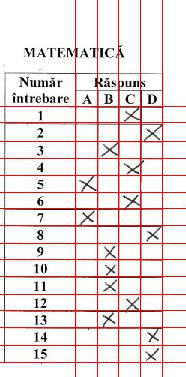

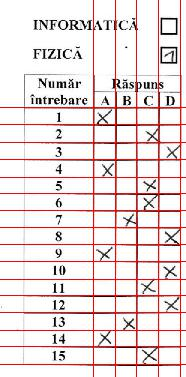

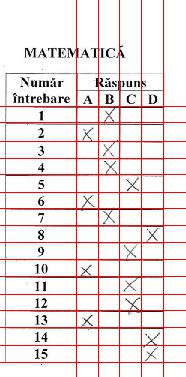

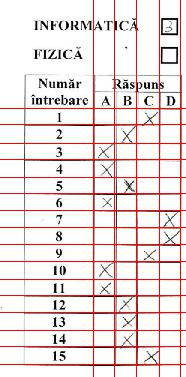

In [286]:

for i in range(0, 2):
    image = read_image(i)
    image_left = split_first_table(image)
    image_right = split_second_table(image)

    show_image(apply_lines(image_left))
    show_image(apply_lines(image_right))


In [270]:
# testing flow
# read image

img = read_image(image_index)

# cut image
img = split_first_table(img)

show_image(img)
#apply filters
img_gray = apply_filters(img)

# obtain binary image
filtered_h = filter_horizontal(img_gray)

horizontal_l = get_horizontal_lines(filtered_h, 15)
show_image(horizontal_l)

In [52]:
# # testing written functions
# img = read_image(image_index)
# img1 = split_first_table(img)
# img2 = split_second_table(img)
# # show_image(img1)
# # show_image(img2)
# img1_gray = apply_filters(img1)
# show_image(img1_gray)
# img1_filtered_vertical = filter_vertical(img1_gray)
# show_image(img1_filtered_vertical)
# vertical_l = get_vertical_lines(img1_filtered_vertical, 15)
# show_image(vertical_l)

In [13]:
len(images)

150